In [1]:
import os
from evaluation.step_eval import StepStats, ATTEMPTS_NAME
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/coq-modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-02-02 17:13:17,192] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
files = [
   ("Basic 8 pct", "/home/ubuntu/coq-modeling/step-evals/basic-rnd-split-rnd-samp-8-pct"),
]

In [3]:
def filter_empty_evals(step_stats: dict[str, StepStats]) -> dict[str, StepStats]:
    filtered: dict[str, StepStats] = {}
    for file, stats in step_stats.items(): 
        if 0 not in stats.stats_dict:
            continue
        filtered[file] = stats
    return filtered


In [4]:
def get_shared_files_and_avgs(stats_by_eval: list[dict[str, StepStats]]) -> dict[str, float]:
    assert len(stats_by_eval) > 0
    new_key_set = set(stats_by_eval[0].keys())
    for file_stats_dic in stats_by_eval[1:]:
        new_key_set &= set(file_stats_dic.keys())
    
    file_avgs: dict[str, float] = {}
    for key in new_key_set:
        total_steps = 0
        for eval_stats in stats_by_eval:
            total_steps += eval_stats[key].at(0).attempted_steps
        file_avgs[key] = total_steps / len(stats_by_eval)
    return file_avgs

In [5]:
def get_eval_files(eval_dir: str) -> dict[str, StepStats]:
    attempts_loc = os.path.join(eval_dir, ATTEMPTS_NAME)
    file_stats_map: dict[str, StepStats] = {}
    for dp_name in os.listdir(attempts_loc):
        dp_loc = os.path.join(attempts_loc, dp_name)
        file_stats = StepStats.load(dp_loc)
        file_stats_map[dp_name] = file_stats
    return file_stats_map 

Text(0.5, 1.0, 'Proof Rate by File for Longest Files in Val Set')

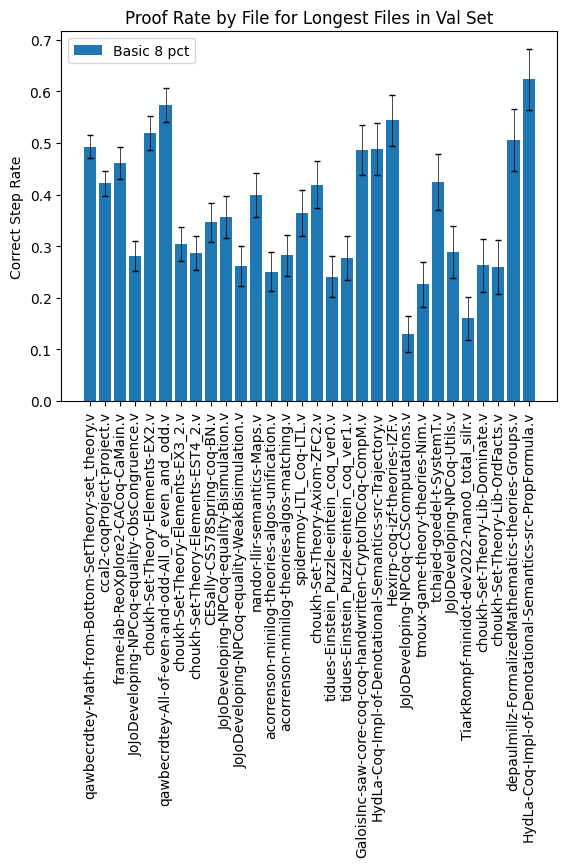

In [11]:
eval_objs = [get_eval_files(d) for _, d in files]
filtered_empty = [filter_empty_evals(s) for s in eval_objs]
shared_files = get_shared_files_and_avgs(filtered_empty)
file_ordered_tups = sorted(shared_files.items(), key=lambda x: -1 * x[1]) 
sorted_files = [f for f, _ in file_ordered_tups]

plot_top_files = 30
plot_files = sorted_files[:plot_top_files]
fig, ax = plt.subplots()
for i, eval_obj in enumerate(filtered_empty):
    vals: list[float] = []
    errs: list[float] = []
    for file in plot_files:
        vals.append(eval_obj[file].at(0).compute())
        errs.append(eval_obj[file].at(0).margin())
    xs = np.arange(plot_top_files)
    ax.bar(plot_files, vals, label=files[i][0])
    ax.errorbar(xs, vals, yerr=errs, fmt="none", ecolor="black", capsize=2, elinewidth=0.5)
ax.set_xticks(np.arange(plot_top_files))
ax.set_xticklabels(plot_files, rotation=90)
ax.set_ylabel("Correct Step Rate")
ax.legend()
ax.set_title("Proof Rate by File for Longest Files in Val Set")
    
    
